In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import spotipy
#from spotipy.oauth2 import SpotifyOAuth
#import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import requests
import json
import logging

In [9]:
# Autenticación y Conexion
client_id = 'TuClientID'
client_secret = 'TuClientSecret'
redirect_uri = "http://localhost:3000"
scope = "user-library-read playlist-read-private playlist-modify-public playlist-modify-private"

def test_spotify_connection():
    try:
        sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
            client_id=client_id,
            client_secret=client_secret,
            redirect_uri=redirect_uri,
            scope=scope
        ))                                        
        # Intentar obtener el perfil del usuario autenticado como prueba
        user_profile = sp.current_user()
        print("Conexión exitosa. Perfil del usuario:")
        print(user_profile)
        return sp, user_profile['id']  # Devolver el objeto sp y el user_id si la conexión fue exitosa

    except spotipy.exceptions.SpotifyException as e:
        print(f"Error de conexión LPM!!!: {e}")
        return None, None

def get_all_data(sp, user_id):
    track_list = []
    sname_list = []
    artist_list = []

    # Inicializar listas para características de audio
    danceability_list = []
    energy_list = []
    key_list = []
    loudness_list = []
    mode_list = []
    speechiness_list = []
    acousticness_list = []
    instrumentalness_list = []
    liveness_list = []
    valence_list = []
    tempo_list = []

    try:
        playlists = sp.user_playlists(user_id)['items']
    except Exception as e:
        print(f"Error fetching playlists: {e}")
        return pd.DataFrame()  # Devuelve un DataFrame vacío en caso de error

    for playlist in tqdm(playlists, desc="Listas de reproducción procesadas"):
        try:
            tracks = sp.playlist_tracks(playlist['id'])['items']
        except Exception as e:
            print(f"Error fetching tracks for playlist {playlist['id']}: {e}")
            continue  # Continúa con la siguiente lista de reproducción en caso de error

        for track in tracks:
            if track['track'] and track['track']['id']:
                track_list.append(track['track']['id'])
                sname_list.append(track['track']['name'])
                artist_list.append(", ".join([artist['name'] for artist in track['track']['artists']]))

    # Llamadas en lotes a sp.audio_features para mayor eficiencia
    try:
        for i in tqdm(range(0, len(track_list), 100), desc="Características de audio obtenidas"):
            batch_audio_ft = sp.audio_features(track_list[i:i+100])
            for audio_ft in batch_audio_ft:
                if audio_ft:  # Comprobar que audio_ft no es None
                    danceability_list.append(audio_ft['danceability'])
                    energy_list.append(audio_ft['energy'])
                    key_list.append(audio_ft['key'])
                    loudness_list.append(audio_ft['loudness'])
                    mode_list.append(audio_ft['mode'])
                    speechiness_list.append(audio_ft['speechiness'])
                    acousticness_list.append(audio_ft['acousticness'])
                    instrumentalness_list.append(audio_ft['instrumentalness'])
                    liveness_list.append(audio_ft['liveness'])
                    valence_list.append(audio_ft['valence'])
                    tempo_list.append(audio_ft['tempo'])
                else:
                    # Si no hay características de audio, agregar valores nulos
                    danceability_list.append(None)
                    energy_list.append(None)
                    key_list.append(None)
                    loudness_list.append(None)
                    mode_list.append(None)
                    speechiness_list.append(None)
                    acousticness_list.append(None)
                    instrumentalness_list.append(None)
                    liveness_list.append(None)
                    valence_list.append(None)
                    tempo_list.append(None)
    except Exception as e:
        print(f"Error fetching audio features: {e}")
        return pd.DataFrame()  # Devuelve un DataFrame vacío en caso de error

    df = pd.DataFrame({
        'name': sname_list,
        'artist': artist_list,
        'id': track_list,
        'danceability': danceability_list,
        'energy': energy_list,
        'key': key_list,
        'loudness': loudness_list,
        'mode': mode_list,
        'speechiness': speechiness_list,
        'acousticness': acousticness_list,
        'instrumentalness': instrumentalness_list,
        'liveness': liveness_list,
        'valence': valence_list,
        'tempo': tempo_list
    })

    return df

# Escalar y aplicación K-means
def scale_and_cluster(df, n_clusters=5):
    features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                'instrumentalness', 'liveness', 'valence', 'tempo']

    # Filtrar las características de audio
    X = df[features]

    # Escalado
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    df_scaled = pd.DataFrame(X_scaled, columns=features)
    
    # Aplicamos K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)

    # Agregar etiquetas al DataFrame original
    df['cluster'] = kmeans.labels_

    return df, kmeans, X_scaled, df_scaled

# Método del codo para encontrar el número óptimo de clusters
def elbow_method(X_scaled, max_k=10):
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k + 1), inertia, marker='o', linestyle='-', color='b')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inercia')
    plt.title('Método del codo')
    plt.xticks(range(1, max_k + 1))
    plt.grid(True)
    plt.show()
    return inertia

# Calcular y graficar el coeficiente de silueta para varios valores de k
def silhouette_analysis(X_scaled, max_k=10):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Coeficiente de silueta')
    plt.title('Análisis de silueta')
    plt.show()
    return silhouette_scores

# Análisis BIC para encontrar el número óptimo de clusters usando GMM
def bic_gmm_analysis(X_scaled, max_k=10):
    bic_scores = []
    for k in range(1, max_k + 1):
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(X_scaled)
        bic_scores.append(gmm.bic(X_scaled))
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k + 1), bic_scores, marker='o')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('BIC')
    plt.title('Análisis BIC para Gaussian Mixture Models')
    plt.show()
    return bic_scores

# Visualizar los clusters usando PCA
def visualize_clusters(df, X_scaled, n_clusters):
    pca = PCA(n_components=2)
    components = pca.fit_transform(X_scaled)
    df['pca_1'] = components[:, 0]
    df['pca_2'] = components[:, 1]
    plt.figure(figsize=(10, 8))
    for cluster in range(n_clusters):
        cluster_data = df[df['cluster'] == cluster]
        plt.scatter(cluster_data['pca_1'], cluster_data['pca_2'], label=f'Cluster {cluster}')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('Visualización de clusters usando PCA')
    plt.legend()
    plt.show()

# Función para crear gráficos de araña
def create_radar_chart(df, features, cluster_labels):
    # Número de variables
    num_vars = len(features)
    
    # Ángulo de cada variable en el gráfico de araña
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Cerrar el círculo
    
    # Gráfico de araña para cada cluster
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    for cluster in sorted(df[cluster_labels].unique()):
        cluster_data = df[df[cluster_labels] == cluster]
        mean_values = cluster_data[features].mean().tolist()
        mean_values += mean_values[:1]
        
        ax.fill(angles, mean_values, alpha=0.25, label=f'Cluster {cluster}')
        ax.plot(angles, mean_values, linewidth=2, linestyle='solid')
    
    # Etiquetas de las características
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# Optimizar la función get_recommended_tracks para procesar en lotes
def get_recommended_tracks(sp, track_ids, limit=10):
    recommended_tracks = []
    batch_size = 50  # Tamaño del lote para la API
    for i in tqdm(range(0, len(track_ids), batch_size), desc='Processing tracks'):
        batch = track_ids[i:i+batch_size]
        for track_id in batch:
            try:
                recommendations = sp.recommendations(seed_tracks=[track_id], limit=limit)['tracks']
                recommended_tracks.extend([track['id'] for track in recommendations])
            except Exception as e:
                print(f"Error obteniendo recomendaciones para {track_id}: {e}")
    return recommended_tracks

# Optimizar la creación de playlists
def create_playlist_and_add_tracks(sp, user_id, playlist_name, track_ids):
    # Crear la playlist
    playlist = sp.user_playlist_create(user_id, playlist_name)
    batch_size = 100  # Tamaño del lote para agregar pistas
    for i in tqdm(range(0, len(track_ids), batch_size), desc=f'Adding tracks to {playlist_name}'):
        batch = track_ids[i:i+batch_size]
        sp.user_playlist_add_tracks(user_id, playlist['id'], batch)

Conexión exitosa. Perfil del usuario:
La conexión a la API de Spotify fue exitosa.
User ID: rx4dw2qma9fzxhnmrsqog3u74


Características de audio obtenidas: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


Datos obtenidos: (816, 14)


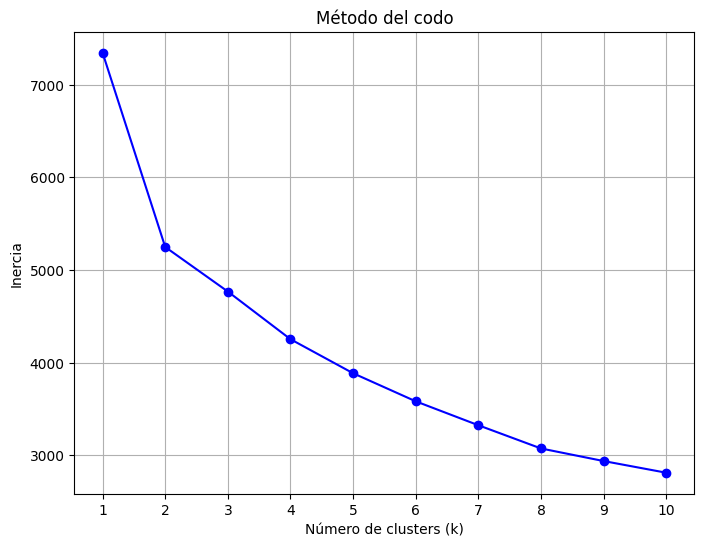

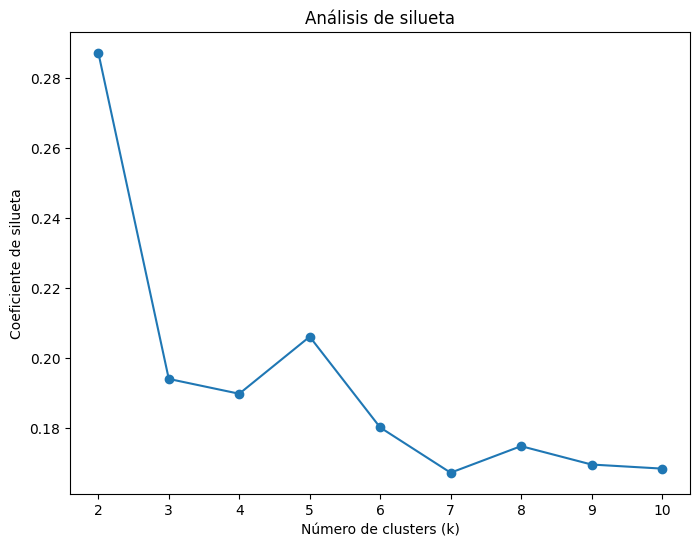

El número óptimo de clusters según el análisis de silueta es: 2


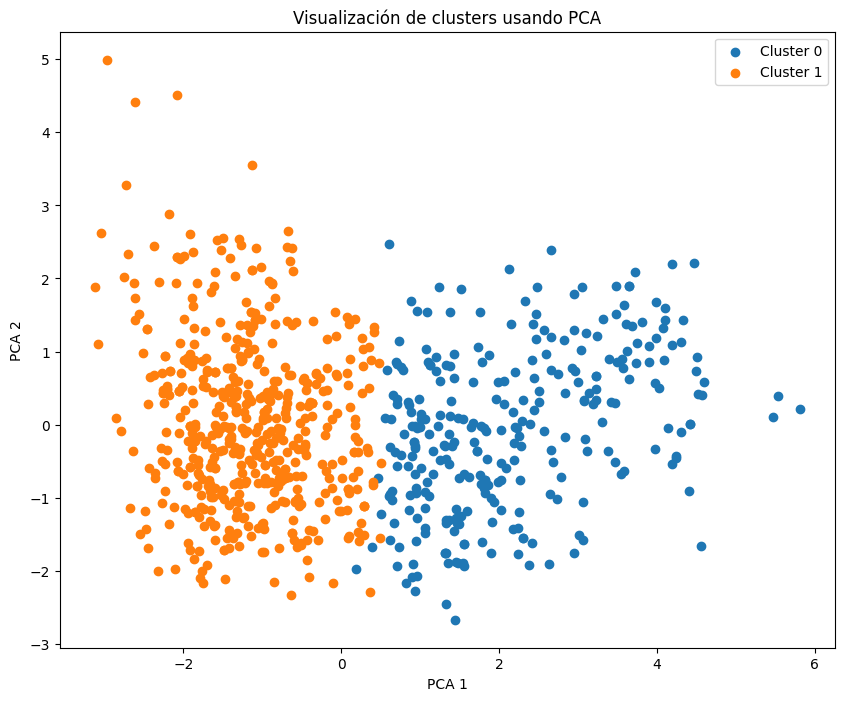

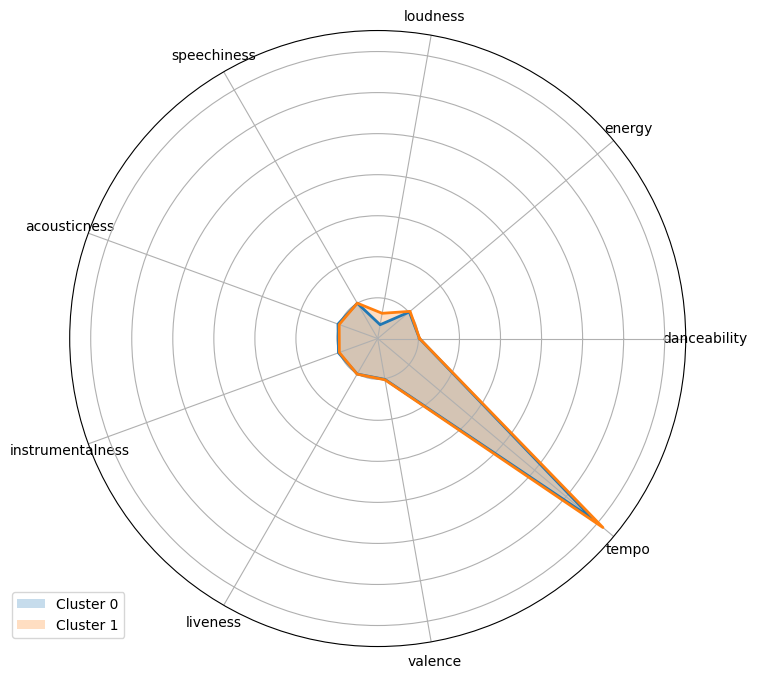

In [11]:
# Ejecución del código para probar la conexión y obtener datos
sp, user_id = test_spotify_connection()

if sp:
    print("La conexión a la API de Spotify fue exitosa.")
    print(f"User ID: {user_id}")
    
    # Obtener todos los datos de las listas de reproducción del usuario
    data_df = get_all_data(sp, user_id)

    # Guardar los datos obtenidos en un csv
    data_df.to_csv('datos_obtenidos.csv', index=False)

    if not data_df.empty:
        print(f"Datos obtenidos: {data_df.shape}")
        
        # Escalar y aplicar K-means
        clustered_df, kmeans_model, X_scaled, df_scaled = scale_and_cluster(data_df, n_clusters=5)
        
        # Guardar los datos escalados en un DataFrame
        df_scaled.to_csv('datos_escalados.csv', index=False)

        # Método del codo para determinar el número óptimo de clusters
        inertia = elbow_method(X_scaled, max_k=10)
        
        # Análisis de silueta
        silhouette_scores = silhouette_analysis(X_scaled, max_k=10)

        # Análisis BIC
        bic_scores = bic_gmm_analysis(X_scaled, max_k=10)

        # Determinar el mejor valor de k basado en el método del codo y el análisis de silueta
        '''       
        El análisis de silueta no es útil para 𝑘=1. Porque el coeficiente de silueta mide la calidad de la separación 
        entre clusters. Si hay solo un cluster (k=1), no hay separación para evaluar, lo que hace que el coeficiente de 
        silueta no tenga sentido en ese contexto. Por lo tanto, el análisis de silueta generalmente comienza en 𝑘=2
        '''
        best_k = silhouette_scores.index(max(silhouette_scores)) + 2  # Silhouette analysis starts at k=2
        ### best_k = 5  # Usamos 5 clusters para esta prueba
        print(f"El número óptimo de clusters según el análisis de silueta es: {best_k}")

        # Volver a escalar y aplicar K-means con el mejor valor de k
        clustered_df, kmeans_model, X_scaled, df_scaled = scale_and_cluster(data_df, n_clusters=best_k)

        visualize_clusters(clustered_df, X_scaled, n_clusters=best_k)
        
        # Crear gráficos de araña
        audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                          'instrumentalness', 'liveness', 'valence', 'tempo']
        create_radar_chart(clustered_df, audio_features, 'cluster')  
else:
    print("Hubo un error al conectar a la API de Spotify.")


In [19]:
def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
            for i in range(wanted_parts)]

def get_recommendations(sp, track_ids, limit=20):
    """
    Obtiene recomendaciones de canciones basadas en una lista de pistas existentes.

    sp: Objeto de conexión de Spotipy.
    track_ids: Lista de IDs de canciones para obtener recomendaciones.
    limit: Número de canciones recomendadas a obtener.
    Lista de IDs de canciones recomendadas.
    """
    recommendations = sp.recommendations(seed_tracks=track_ids, limit=limit)
    recommended_track_ids = [track['id'] for track in recommendations['tracks']]
    return recommended_track_ids

def create_cluster_playlist(df, sp, user_id):
    """
    Crea playlists en Spotify para cada cluster con canciones recomendadas.

    df: DataFrame con las canciones y clusters.
    sp: Objeto de conexión de Spotipy.
    user_id: ID del usuario de Spotify.
    """
    for cluster in df['cluster'].value_counts().index.tolist():
        original_uris = df[df.cluster == cluster]['id'].tolist()
        recommended_uris = []

        # Obtener recomendaciones basadas en las canciones del cluster
        if len(original_uris) > 5:
            track_ids_for_recommendation = original_uris[:5]  # Limitar a 5 pistas para obtener recomendaciones
        else:
            track_ids_for_recommendation = original_uris
        
        recommended_uris = get_recommendations(sp, track_ids_for_recommendation, limit=100)

        # Crear la playlist
        create_playlist_endpoint = f"https://api.spotify.com/v1/users/{user_id}/playlists"
        request_body_playlist = json.dumps({
            "name": f"Cluster {cluster} Playlist",
            "description": f"Playlist del cluster nro {cluster}, creada para Modelado de Datos.",
            "public": False ##True
        })
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {sp.auth_manager.get_access_token(as_dict=False)}"
        }
        
        response = requests.post(url=create_playlist_endpoint, data=request_body_playlist, headers=headers)
        
        if response.status_code == 201:
            print(f"La playlist del cluster {cluster} fue correctamente creada")
        else:
            print(f"Hubo un error en la creación de la playlist del cluster {cluster}")
            print(f"{response.status_code}: {response.text}")
            continue
        
        playlist_id = response.json()['id']
        print("Agregando canciones a la playlist")
        
        # Agregar canciones a la playlist
        for uri_chunk in split_list(recommended_uris, wanted_parts=(len(recommended_uris) // 100 + 1)):
            add_track_endpoint = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
            request_add_tracks = json.dumps({
                "uris": [f'spotify:track:{uri}' for uri in uri_chunk]
            })
            response = requests.post(url=add_track_endpoint, data=request_add_tracks, headers=headers)
        
            if response.status_code == 201 or response.status_code == 200:
                print(f"Se agregaron {len(uri_chunk)} canciones a la playlist")
            else:
                print(f"Error al agregar canciones a la playlist")
                print(f"{response.status_code}: {response.text}")
                print(len(uri_chunk))
                continue

    print("Finalizada la creación de las playlists")

In [20]:
# Crear listas de reproducción en Spotify para cada cluster con canciones recomendadas
create_cluster_playlist(clustered_df, sp, user_id)

La playlist del cluster 0 fue correctamente creada
Agregando canciones a la playlist
Se agregaron 50 canciones a la playlist
Se agregaron 50 canciones a la playlist
La playlist del cluster 1 fue correctamente creada
Agregando canciones a la playlist
Se agregaron 50 canciones a la playlist
Se agregaron 50 canciones a la playlist
Finalizada la creación de las playlists


El método del codo, en cambio, incluye 𝑘=1
k=1 porque la inercia (o suma de errores cuadráticos dentro del cluster) se puede calcular incluso con un solo cluster, aunque no proporciona información sobre la calidad de la separación entre clusters.